## Preprocesamiento

#### Importación de las librerías

In [406]:
import importlib

import utils.plot_utils as plot_utils
import utils.plot_utils as encode_utils
import utils.feature_utils as feature_utils
importlib.reload(plot_utils)
importlib.reload(encode_utils)
importlib.reload(feature_utils)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.feather as feather

from sklearn.feature_selection import mutual_info_classif
from funpymodeling.exploratory import status
from sklearn.impute import KNNImputer
from utils.plot_utils import display_dataset_distributions
from utils.plot_utils import display_dataset_categorical, plot_box_whiskers, plot_correlation_heatmap
from utils.encode_utils import boolean_encoding
from utils.feature_utils import discretize_variable, eliminate_outliers_capping, eliminate_high_corr_columns

pd.options.mode.chained_assignment = None


### Obtención del dataset

In [364]:
# Se cargan los datasets
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
dataset = pd.concat([train, test], ignore_index=True)

In [365]:
# Se imprimen las primeras filas del dataset
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Análisis inicial de los datos

In [366]:
# Se obtiene el tipo de dato de cada columna 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      1298

In [367]:
# Se decribe cada columna con estadísticas básicas
status(dataset)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Unnamed: 0,0,0.000000,2,0.000015,103904,int64
1,id,0,0.000000,0,0.000000,129880,int64
2,Gender,0,0.000000,0,0.000000,2,object
3,Customer Type,0,0.000000,0,0.000000,2,object
4,Age,0,0.000000,0,0.000000,75,int64
5,Type of Travel,0,0.000000,0,0.000000,2,object
6,Class,0,0.000000,0,0.000000,3,object
7,Flight Distance,0,0.000000,0,0.000000,3821,int64
8,Inflight wifi service,0,0.000000,3916,0.030151,6,int64
9,Departure/Arrival time convenient,0,0.000000,6681,0.051440,6,int64


In [368]:
dataset.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,44158.700000,64940.500000,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,31207.377062,37493.270818,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16234.750000,32470.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,38963.500000,64940.500000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,71433.250000,97410.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [369]:
# Se definen las columans relevantes, se elimina el ID
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction']

# Se define el split entre variables de entrada y de salida
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [370]:
# Se transforman algunas variables a float para poder graficar
def convert_float(dataset, cols):
    dataset[cols] = dataset[cols].astype(float)

In [371]:
cols = ["Flight Distance", "Departure Delay in Minutes", "Age"]
for data in [X_train, X_test]:
    convert_float(data, cols)

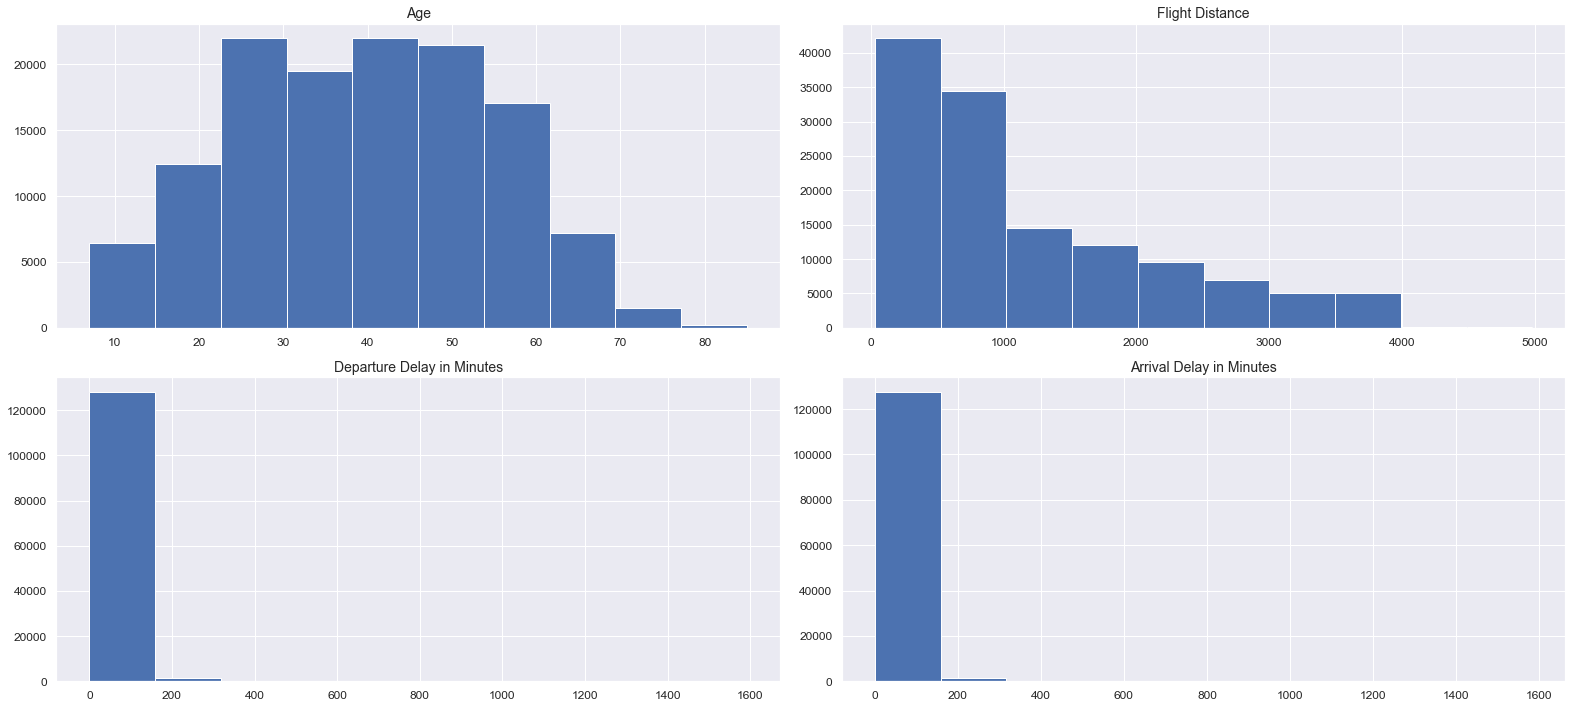

In [372]:
# Se grafican los datos flotantes
X = pd.concat([X_train, X_test], ignore_index=True)
display_dataset_distributions(X.select_dtypes(include=["float64"]))

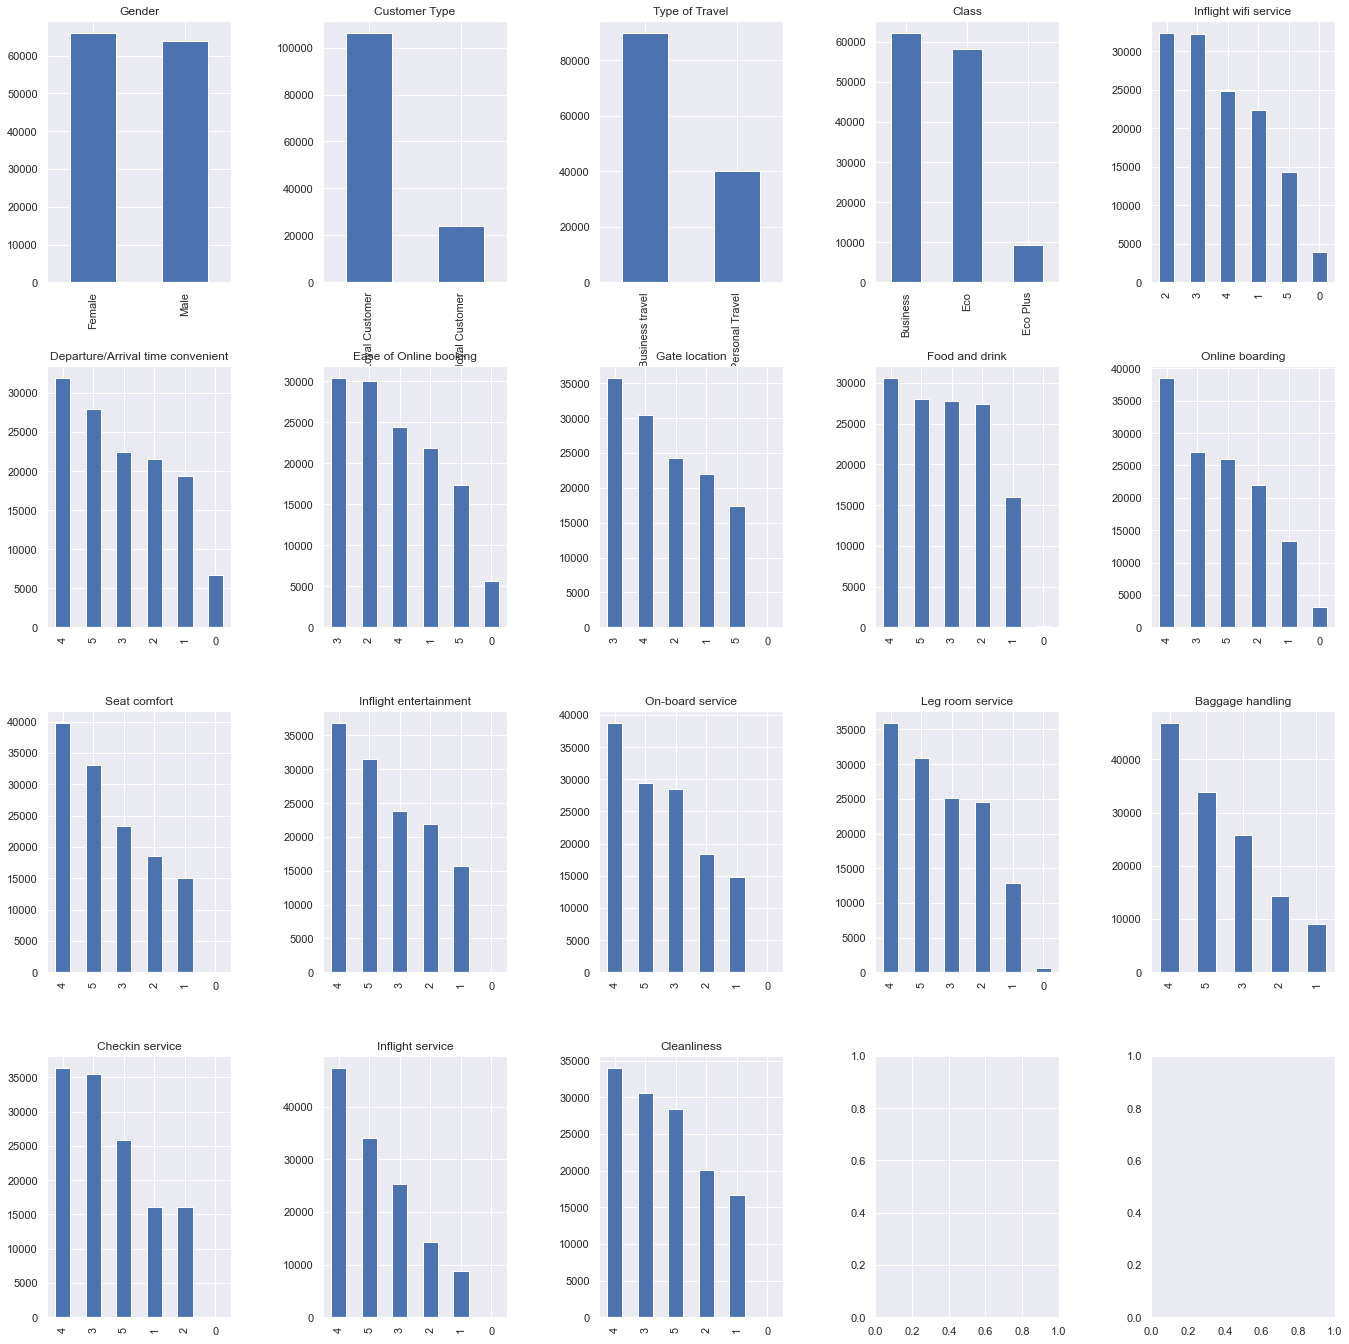

In [373]:
# Se grafican los datos categóricos y los enteros
display_dataset_categorical(X.select_dtypes(include=["object", "int64"]), n_rows=4, figsize=(20, 20))

<AxesSubplot:xlabel='satisfaction'>

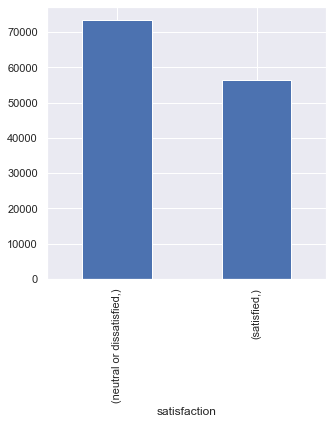

In [374]:
# Se grafica la variable de salida
y = pd.concat([y_train, y_test], ignore_index=True)
y.value_counts().plot(kind="bar", figsize=(5, 5), grid=True)

### Limpieza de los datos

In [375]:
# Se obtiene el número de datos faltantes en la variable de salida
y.isna().sum()

satisfaction    0
dtype: int64

In [376]:
# Se obtiene el número de datos faltantes por columna
X.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

In [377]:
# Se obtiene el porcentaje de NaNs por columna
X.isna().sum() / X.shape[0] * 100

Gender                               0.000000
Customer Type                        0.000000
Age                                  0.000000
Type of Travel                       0.000000
Class                                0.000000
Flight Distance                      0.000000
Inflight wifi service                0.000000
Departure/Arrival time convenient    0.000000
Ease of Online booking               0.000000
Gate location                        0.000000
Food and drink                       0.000000
Online boarding                      0.000000
Seat comfort                         0.000000
Inflight entertainment               0.000000
On-board service                     0.000000
Leg room service                     0.000000
Baggage handling                     0.000000
Checkin service                      0.000000
Inflight service                     0.000000
Cleanliness                          0.000000
Departure Delay in Minutes           0.000000
Arrival Delay in Minutes          

Se procede a transformar las variables categóricas en numéricas para poder imputar usando KNN

### Ingeniería de features

In [378]:
# Transformar clase
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1

# Transforma strings que toman dos valores en valores de 1 y 0
def boolean_encoding(df, column_name, mapping={"Yes": 1, "No": 0}, default=-1):
    df[column_name] = getattr(df, column_name).map(mapping).fillna(default).astype(int)
    return df

# Se transforman las variables categóricas
features = ['Gender', 'Customer Type', 'Type of Travel']
for data in [X_train, X_test]:
    data = boolean_encoding(data, 'Gender', mapping={"Male": 1, "Female": 0})
    data = boolean_encoding(data, 'Customer Type', mapping={"Loyal Customer": 1, "disloyal Customer": 0})
    data = boolean_encoding(data, 'Type of Travel', mapping={"Business travel": 1, "Personal Travel": 0})
    data['Class'] = data['Class'].apply(transform_class)

for data in [y_train, y_test]:
    boolean_encoding(data, 'satisfaction', mapping={"satisfied": 1, "neutral or dissatisfied": 0})

In [379]:
# Se verifican los tipos de datos
status(X_train)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Gender,0,0.000000,52727,0.507459,2,int32
1,Customer Type,0,0.000000,18981,0.182678,2,int32
2,Age,0,0.000000,0,0.000000,75,float64
3,Type of Travel,0,0.000000,32249,0.310373,2,int32
4,Class,0,0.000000,46745,0.449886,3,int64
5,Flight Distance,0,0.000000,0,0.000000,3802,float64
6,Inflight wifi service,0,0.000000,3103,0.029864,6,int64
7,Departure/Arrival time convenient,0,0.000000,5300,0.051009,6,int64
8,Ease of Online booking,0,0.000000,4487,0.043184,6,int64
9,Gate location,0,0.000000,1,0.000010,6,int64


In [380]:
# Se imputa usando KNN
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(X_train)
for data in [X_train, X_test]:
    data[:] = imputer.transform(data)

status(X_train)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Gender,0,0.0,52727,0.507459,2,float64
1,Customer Type,0,0.0,18981,0.182678,2,float64
2,Age,0,0.0,0,0.000000,75,float64
3,Type of Travel,0,0.0,32249,0.310373,2,float64
4,Class,0,0.0,46745,0.449886,3,float64
5,Flight Distance,0,0.0,0,0.000000,3802,float64
6,Inflight wifi service,0,0.0,3103,0.029864,6,float64
7,Departure/Arrival time convenient,0,0.0,5300,0.051009,6,float64
8,Ease of Online booking,0,0.0,4487,0.043184,6,float64
9,Gate location,0,0.0,1,0.000010,6,float64


#### Tratamiento de outliers

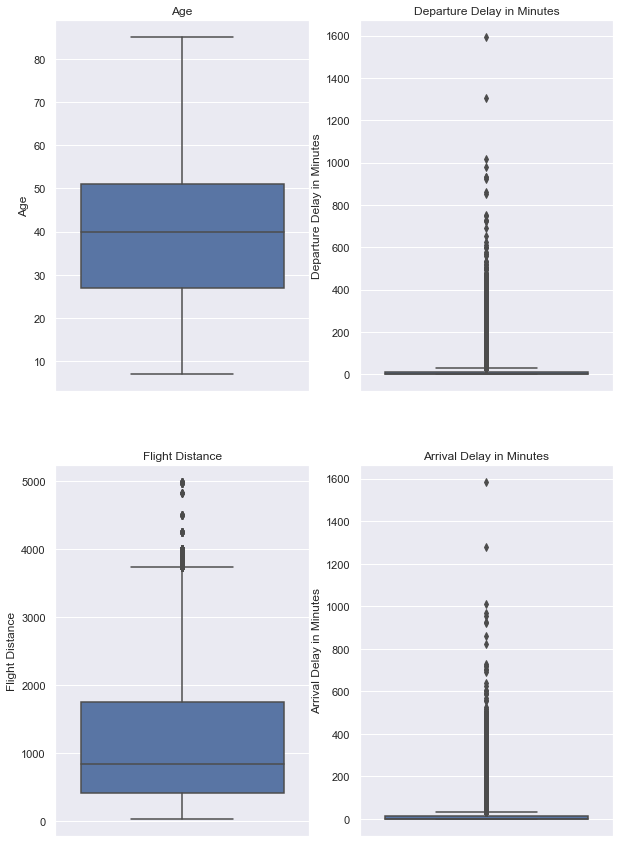

In [381]:
features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
plot_box_whiskers(X_train, features, row_num=2, figsize=(10, 15))

C:\Users\gromero\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\gromero\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\gromero\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\gromero\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are r

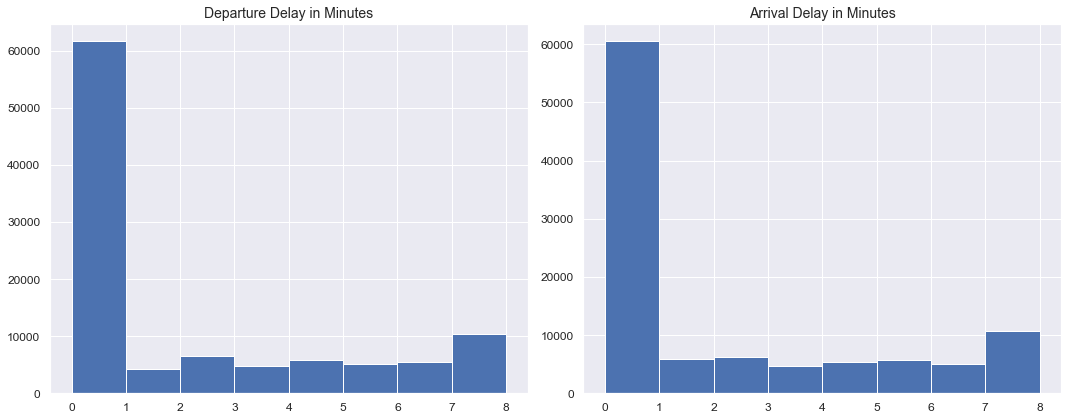

In [382]:
from sklearn.preprocessing import KBinsDiscretizer

def discretize_variable(df, variable, n_bins=4, strategy="kmeans"):
    print
    kbins = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
    df[variable] = kbins.fit_transform(df[variable].to_numpy().reshape(-1, 1))
    return df

# Dado que algunas variables presentan alta oblicuidad, se procede a discretizar la variable
discretize_list = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']

for data in [X_train, X_test]:
    for var in discretize_list:
        discretize_variable(data, var, n_bins=20, strategy="quantile")

display_dataset_distributions(X_train[discretize_list], unique=True, figsize=(15, 6))

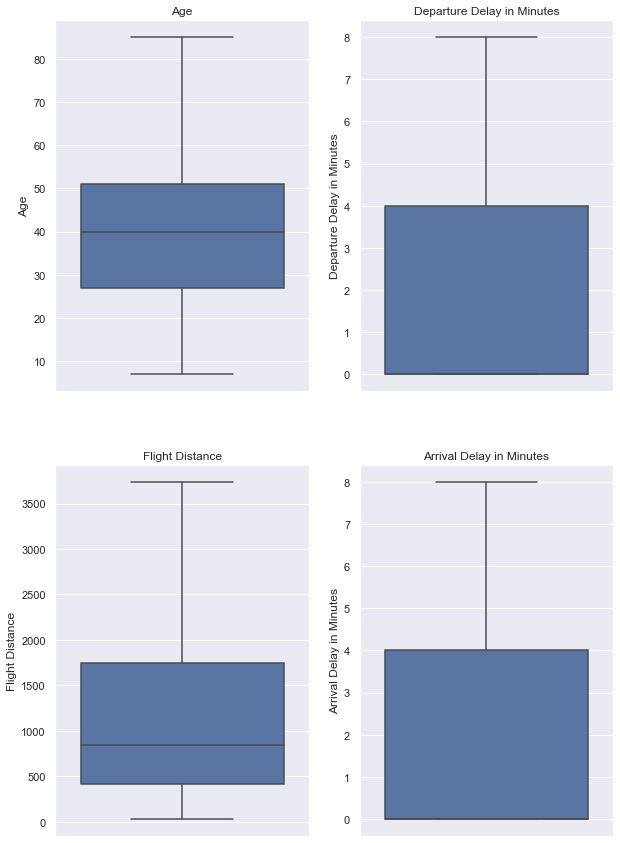

In [383]:
# Se eliminan los outliers usando capping
features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
for data in [X_train, X_test]:
    data[:] = eliminate_outliers_capping(data.copy(), features)

plot_box_whiskers(X_train, features, row_num=2, figsize=(10, 15))

#### Correlación entre variables

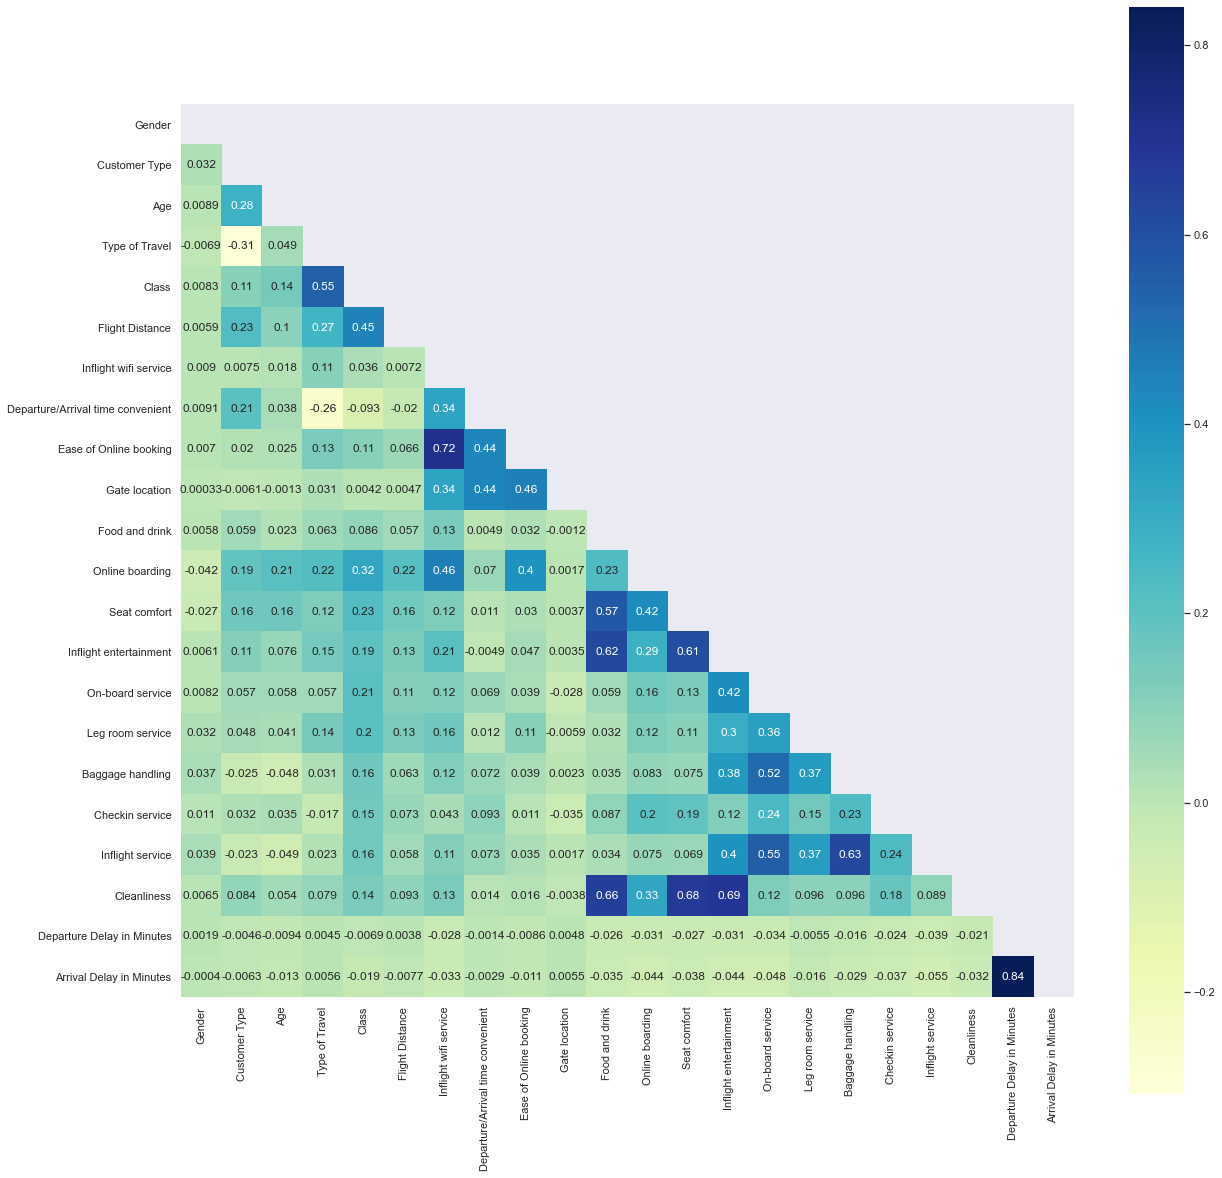

In [384]:
# Se grafica la correlación
plot_correlation_heatmap(X_train)

In [385]:
# Se eliminan columnas altamente correlacionadas

X_train = eliminate_high_corr_columns(X_train, max_corr=0.8)
X_test = eliminate_high_corr_columns(X_test, max_corr=0.8)

Eliminated columns: ['Departure Delay in Minutes']
Eliminated columns: ['Departure Delay in Minutes']


In [386]:
# Se obtiene la información mutua
mutual_info = pd.DataFrame(mutual_info_classif(X_train, y_train.to_numpy().ravel()).reshape(-1, 1))
mutual_info = mutual_info.set_index(X_train.columns)

In [387]:
mutual_info.sort_values(by=[0], ascending=False)

,0
Online boarding,0.213398
Inflight wifi service,0.164725
Class,0.140440
Type of Travel,0.122719
Inflight entertainment,0.096439
Seat comfort,0.083585
Leg room service,0.061507
On-board service,0.060741
Flight Distance,0.060134
Ease of Online booking,0.055224


In [391]:
drop_cols = ["Gender", "Departure/Arrival time convenient"]
X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)

#### Guardar dataset preprocesado

In [405]:
feather.write_feather(X_train, './results/X_train.ftr')
feather.write_feather(X_test, './results/X_test.ftr')
feather.write_feather(y_train, './results/y_train.ftr')
feather.write_feather(y_test, './results/y_test.ftr')